In [1]:
# importing packages

# 기본 패키지

from google.colab import drive
import pandas as pd
import numpy as np
import warnings

# Future warning 무시

warnings.filterwarnings("ignore", category=FutureWarning)

# 시각화 패키지

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

# 데이터 분석 패키지

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
# import optuna
import xgboost as xgb
from xgboost.callback import EarlyStopping
from sklearn.metrics import f1_score
from sklearn.model_selection import RepeatedStratifiedKFold
import warnings

In [2]:
# 머신러닝 모델
#!pip install tabpfn
# Local development installation
#!git clone https://github.com/PriorLabs/TabPFN.git
#!pip install -e "TabPFN[dev]"
from tabpfn import TabPFNClassifier
!pip install torch # Install PyTorch
import torch # Import the PyTorch library

In [4]:
# 항상 저장할 것...

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 한글 폰트 다운로드

!sudo apt-get install -y fonts-nanum
!fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 한글 폰트 설정
plt.rc("font", family="NanumGothic")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [6]:
# 데이터 업로드

train = pd.read_csv('/content/drive/My Drive/train.csv')
test = pd.read_csv('/content/drive/My Drive/test.csv')

#train = pd.read_csv('/content/train.csv')
#test = pd.read_csv('/content/test.csv')

### 데이터 전처리

In [ ]:
#NA개수: 변수 생성

# train["NA개수"] = train.isnull().sum(axis=1)
# test["NA개수"] = test.isnull().sum(axis=1)

In [7]:
# 결측치 처리 함수: transform

def transform(data):
    # 원본 데이터 수정 방지 (사본 생성)
    data_og = data.copy()

    # 0. NA여부 변수 생성: 각 행별로 아래 조건에 따라 라벨 부여
    def assign_na_label(row):
        # 월세가 0인 경우
        if row["월세"] == 0:
            return 3
        # '방수', '해당층', '욕실수', '총층' 중 하나라도 NA인 경우
        elif pd.isnull(row["방수"]) or pd.isnull(row["해당층"]) or pd.isnull(row["욕실수"]) or pd.isnull(row["총층"]):
            return 2
        # '전용면적' 또는 '주차가능여부'가 NA인 경우
        elif pd.isnull(row["전용면적"]) or pd.isnull(row["총주차대수"]):
            return 1
        else:
            return 0

    data["NA여부"] = data.apply(assign_na_label, axis=1)

    # 1. '전용면적' 결측값을 중앙값(median)으로 대체
    data["전용면적"].fillna(data["전용면적"].median(), inplace=True)

    # 2. '총층' 결측값을 중앙값(median)으로 대체
    data["총층"].fillna(data["총층"].median(), inplace=True)

    # 3. '해당층' 결측값을 랜덤 대체 (1 ~ 총층 사이)
    na_indices = data["해당층"].isna()
    data.loc[na_indices, "해당층"] = data.loc[na_indices, "총층"].apply(
        lambda x: np.random.randint(1, x+1)
    )

    # 4. '욕실수', '방수' 결측값을 최빈값(mode)으로 대체
    data["욕실수"].fillna(data["욕실수"].mode()[0], inplace=True)
    data["방수"].fillna(data["방수"].mode()[0], inplace=True)

    # 5. '총주차대수' 처리
    # 5.1. '주차가능여부'가 '불가능'인 경우 '총주차대수'를 0으로 설정
    data.loc[data["주차가능여부"] == "불가능", "총주차대수"] = 0

    # 5.2. '총주차대수' 결측값을 회귀 모델로 예측하여 대체
    valid_data = data.dropna(subset=["총주차대수", "총층"])
    X_data = valid_data[["총층"]].values
    y_data = valid_data["총주차대수"].values
    model = LinearRegression()
    model.fit(X_data, y_data)
    missing_data = data[data["총주차대수"].isna()]
    X_missing = missing_data[["총층"]].values
    data.loc[data["총주차대수"].isna(), "총주차대수"] = np.round(model.predict(X_missing))

    # 6. 월세 처리
    # 월세가 0인 경우 이미 NA여부에 3으로 부여되었으므로,
    # 월세 값 0을 월세가 0이 아닌 관측값들의 평균으로 대체
    mean_월세 = data.loc[data["월세"] != 0, "월세"].mean()
    data.loc[data["월세"] == 0, "월세"] = mean_월세

    return data


In [8]:
# 결측치 처리

train = transform(train)
test = transform(test)
# training set만: outlier drop
train = train[~((train["총주차대수"] == 590) | ((train["총주차대수"] > 120) & (train["총층"] < 10)))]
train = train[train.관리비 < 40]
# 다른 outlier 들도 확인
# EDA 에서 확인 완료! (총주차대수, 관리비만 극심한 outlier 들 존재)

In [ ]:
train

,ID,매물확인방식,보증금,월세,전용면적,해당층,총층,방향,방수,욕실수,주차가능여부,총주차대수,관리비,중개사무소,제공플랫폼,게재일,허위매물여부,NA여부
1,TRAIN_0001,현장확인,170500000.0,200000.0,26.40,3.0,4.0,남동향,2.0,1.0,불가능,0.0,0,q39iV5J4E6,D플랫폼,2024-12-26,0,1
2,TRAIN_0002,전화확인,114000000.0,380000.0,26.40,2.0,3.0,동향,1.0,1.0,불가능,0.0,0,b03oE4G3F6,A플랫폼,2024-11-28,0,1
3,TRAIN_0003,현장확인,163500000.0,30000.0,36.30,3.0,9.0,남동향,2.0,1.0,가능,13.0,10,G52Iz8V2B9,A플랫폼,2024-11-26,0,0
4,TRAIN_0004,현장확인,346000000.0,530000.0,26.40,3.0,3.0,동향,2.0,1.0,불가능,0.0,0,N45gM0M7R0,B플랫폼,2024-06-25,1,1
5,TRAIN_0005,전화확인,153000000.0,530000.0,29.50,2.0,3.0,남향,2.0,1.0,가능,1.0,0,Q42YF3Y0I2,A플랫폼,2024-09-12,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2447,TRAIN_2447,서류확인,159000000.0,550000.0,48.95,3.0,3.0,남향,2.0,1.0,불가능,0.0,0,d22DX4Y4P8,B플랫폼,2024-11-16,0,1
2448,TRAIN_2448,서류확인,158500000.0,750000.0,26.40,2.0,4.0,남향,1.0,1.0,불가능,0.0,2,g99sy3I3R8,A플랫폼,2024-10-06,0,1
2449,TRAIN_2449,전화확인,329000000.0,610000.0,17.50,8.0,20.0,남서향,1.0,1.0,가능,29.0,10,G52Iz8V2B9,B플랫폼,2024-05-15,0,0
2450,TRAIN_2450,현장확인,31000000.0,400000.0,22.87,8.0,9.0,남동향,2.0,1.0,가능,12.0,8,m69GM9O9B3,B플랫폼,2024-08-06,0,1


In [ ]:
train.NA여부.value_counts()

,count
NA여부,
0,1273
1,946
2,223
3,4


In [9]:
# Computing bins

data = train
agency_stats = data.groupby('중개사무소')['허위매물여부'].agg(['sum', 'count'])
# Laplace Smoothing 적용 (s = 허위매물 개수, n = 전체 개수)
alpha = 1.5
agency_stats['허위매물비율'] = (agency_stats['sum'] + alpha) / (agency_stats['count'] + 2 * alpha)
data = data.merge(agency_stats[['허위매물비율']], left_on='중개사무소', right_index=True, how='left')
quantiles = np.quantile(data['허위매물비율'], np.linspace(0, 1, 11))
quantiles = np.unique(quantiles)
bins = [-1] + list(quantiles + 0.0001)
bins

[-1,
 0.0019703241895261845,
 0.14715882352941176,
 0.1924076923076923,
 0.22103023255813953,
 0.2885615384615384,
 0.3126,
 0.3751,
 0.6429571428571429]

In [10]:
# 신뢰등급 지정 (8등급까지)
# 게재일수
max_date = pd.to_datetime(train.게재일.max())

def feature_transform(data, is_train=True, one_hot_encoder=None, label_encoder= None, df = None, bins = None):
    # 'ID' 변수 drop
    data.drop(columns='ID', inplace=True)

    # '게재일수' 변수 추가 ('게재일' 변수 drop)
    data['게재일수'] = (max_date - pd.to_datetime(data['게재일'])).dt.days # 만약 minus 이면?
    # 게재일수가 음수인 경우, 0으로 대체
    data.loc[data['게재일수'] < 0, '게재일수'] = 0
    # '게재일수' 주별로 인코딩 (성능이 떨어짐)
    # 예시: train_transformed 데이터프레임에 '게재일수' 컬럼이 있다고 가정합니다.
    # max_days = data['게재일수'].max()
    # 7일 단위의 bin 경계를 생성합니다.
    # bins_day = np.arange(0, max_days + 7, 7)
    # 각 구간에 대한 라벨 (범주형 값)
    # labels = [f"Week {i}" for i in range(1, len(bins_day))]
    # '게재일수'를 주별로 구간화하여 '게재일수_주별' 생성 (범주형 변수)
    # data['게재일수_주별'] = pd.cut(data['게재일수'], bins=bins_day, labels=labels, include_lowest=True)
    # 범주형 '게재일수_주별'을 순서 정보를 보존한 정수형 값으로 변환
    # data['게재일수_주별'] = data['게재일수_주별'].cat.codes + 1  # +1을 해서 1부터 시작
    data.drop(columns=['게재일'], inplace=True)

    # '주차가능여부' 변수 drop
    data.drop(columns = '주차가능여부', inplace = True)

    # 추가: 총주차대수 log 변환: skewedness 제거 위해
    data['총주차대수'] = np.log1p(data['총주차대수'])

    # '해당층' 변수 drop
    data.drop(columns = '해당층', inplace = True)
    # data.drop(columns = '방수', inplace = True)
    # Random Forest는 다중공산성에 robust 하므로 남겨두자.

    # '욕실수' 변수 drop
    data.drop(columns = '욕실수', inplace = True)

    if is_train:
        # 희소한 '제공플랫폼' 클래스 처리 (등장 비율 2% 미만은 '기타'로 변경 - 원핫인코딩 시 범주가 너무 많아져, 차원을 줄이기 위함) # 2% 로 변경
        threshold = 0.02
        category_counts = data['제공플랫폼'].value_counts(normalize=True)
        rare_categories = category_counts[category_counts < threshold].index
        data['제공플랫폼'] = data['제공플랫폼'].replace(rare_categories, '기타')

        # 원 핫 인코딩 적용할 컬럼
        one_hot_cols = ['방향', '매물확인방식', '제공플랫폼']
        one_hot_encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
        encoded_array = one_hot_encoder.fit_transform(data[one_hot_cols])

    else:
        # Test 데이터: train에서 학습한 one_hot_encoder를 그대로 사용
        one_hot_cols = ['방향', '매물확인방식', '제공플랫폼']
        encoded_array = one_hot_encoder.transform(data[one_hot_cols])

    # 변환된 데이터를 DataFrame으로 변환
    encoded_col_names = one_hot_encoder.get_feature_names_out(one_hot_cols)
    encoded_df = pd.DataFrame(encoded_array, columns=encoded_col_names, index=data.index)

    # 기존 범주형 컬럼 삭제 후 변환된 데이터 합치기
    data.drop(columns=one_hot_cols, inplace=True)
    data = pd.concat([data, encoded_df], axis=1)

    # 중개사무소 라벨 인코딩
    # 1. 허위매물 비율 laplace rule of succession 사용하여 보정
    # 2. 허위매물 비율 활용해 신뢰등급 나누기
    # 3. 라벨 인코딩
    if is_train:
      agency_stats = data.groupby('중개사무소')['허위매물여부'].agg(['sum', 'count'])
      # Laplace Smoothing 적용 (s = 허위매물 개수, n = 전체 개수)
      alpha = 1.5
      agency_stats['허위매물비율'] = (agency_stats['sum'] + alpha) / (agency_stats['count'] + 2 * alpha)
      # 신뢰등급 기준 정의 (허위매물 비율이 낮을수록 높은 등급)
      bins = bins # 구간 설정: 최대한 고르게, 변화를 잘 드러내게
      labels = [1, 2, 3, 4, 5, 6, 7, 8]  # 등급 (낮을수록 신뢰도 높음)
      # 허위매물 비율을 바탕으로 신뢰등급 부여
      agency_stats['신뢰등급'] = pd.cut(agency_stats['허위매물비율'], bins=bins, labels=labels)
      # 원본 데이터에 확률 값 추가
      data = data.merge(agency_stats[['신뢰등급']], left_on='중개사무소', right_index=True, how='left')
      # 신뢰등급 기준 라벨 매핑
      category = np.arange(1, 9)
      label_encoder = OrdinalEncoder(categories = [category],
                        handle_unknown='use_encoded_value', unknown_value= -1) # 아래 코드 때문에 필요없지만
      # 새로운 중개사무소가 나올 경우 ?등급으로 (5등급 = 0.846, 6등급, 7등급 = 0.864 ~ 0.874)
      data['신뢰등급'] = label_encoder.fit_transform(data[['신뢰등급']])
    else:
      data = data.merge(df[['신뢰등급']], left_on='중개사무소', right_index=True, how='left')
      data['신뢰등급'] = data['신뢰등급'].fillna(7)
      # data['count'] = data['count'].fillna(1) # 0 or 1
      data['신뢰등급'] = label_encoder.transform(data[['신뢰등급']])
    # 기존 '중개사무소' 변수 제거 (필요 시)
    data.drop(columns=['중개사무소'], inplace=True)
    return (data, one_hot_encoder, label_encoder, agency_stats) if is_train else data

In [11]:
# 신뢰등급, 라벨 인코딩 사용 시
train, one_hot_encoder, label_encoder, agency_stats = feature_transform(train, is_train= True, bins = bins)
test = feature_transform(test, is_train=False,
                         one_hot_encoder=one_hot_encoder, label_encoder=label_encoder,
                         df = agency_stats)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [12]:
train

,보증금,월세,전용면적,총층,방수,총주차대수,관리비,허위매물여부,NA여부,게재일수,...,매물확인방식_전화확인,매물확인방식_현장확인,제공플랫폼_B플랫폼,제공플랫폼_C플랫폼,제공플랫폼_D플랫폼,제공플랫폼_E플랫폼,제공플랫폼_F플랫폼,제공플랫폼_G플랫폼,제공플랫폼_기타,신뢰등급
1,170500000.0,200000.0,26.40,4.0,2.0,0.000000,0,0,1,67,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0
2,114000000.0,380000.0,26.40,3.0,1.0,0.000000,0,0,1,95,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,163500000.0,30000.0,36.30,9.0,2.0,2.639057,10,0,0,97,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,346000000.0,530000.0,26.40,3.0,2.0,0.000000,0,1,1,251,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,153000000.0,530000.0,29.50,3.0,2.0,0.693147,0,0,2,172,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2447,159000000.0,550000.0,48.95,3.0,2.0,0.000000,0,0,1,107,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2448,158500000.0,750000.0,26.40,4.0,1.0,0.000000,2,0,1,148,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2449,329000000.0,610000.0,17.50,20.0,1.0,3.401197,10,0,0,292,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2450,31000000.0,400000.0,22.87,9.0,2.0,2.564949,8,0,1,209,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0


In [13]:
test.신뢰등급.value_counts()

,count
신뢰등급,
0.0,215
6.0,84
4.0,65
3.0,59
1.0,52
2.0,48
7.0,45
5.0,45


In [ ]:
'''
# === ID 컬럼 제거 ===
train = train.drop(columns=['ID'])
test_id = test['ID']
test = test.drop(columns=['ID'])
'''

In [14]:
x = train.drop(['허위매물여부'],axis=1)
y = train['허위매물여부']

### TabPFN

In [15]:
# === 데이터 정규화 (TabPFN은 정규화 추천) ===
from sklearn.preprocessing import StandardScaler # Import StandardScaler
scaler = StandardScaler()
# x 데이터의 컬럼 이름을 문자열로 변환
x.columns = x.columns.astype(str)  # Add this line

x_scaled = scaler.fit_transform(x)
# test 데이터의 컬럼 이름도 문자열로 변환
test.columns = test.columns.astype(str)  # Add this line

test_scaled = scaler.transform(test)

In [16]:
# SMOTE
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy=0.3,random_state=42)
X_resampled, y_resampled = smote.fit_resample(x_scaled, y)

from collections import Counter
print(Counter(y), Counter(y_resampled))

Counter({0: 2148, 1: 298}) Counter({0: 2148, 1: 644})


In [17]:
# === Out-of-Fold 예측값 및 Test 예측값 초기화 ===
oof_preds = np.zeros(len(x_scaled))
test_preds = np.zeros(len(test))

# 모델 생성
model = TabPFNClassifier(device='cuda' if torch.cuda.is_available() else 'cpu')
# 모델 학습 (TabPFN은 1회 학습으로 충분)
model.fit(X_resampled, y_resampled)
# 예측 및 저장
oof_preds = model.predict_proba(x_scaled)[:, 1]  # 훈련 데이터 예측값 저장
test_preds = model.predict_proba(test_scaled)[:, 1]  # 테스트 데이터 예측값 저장

/content/TabPFN/src/tabpfn/base.py:88: UserWarning: Downloading model to /root/.cache/tabpfn/tabpfn-v2-classifier.ckpt.
  model, _, config_ = load_model_criterion_config(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tabpfn-v2-classifier.ckpt:   0%|          | 0.00/29.0M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

In [18]:
# === 검증 데이터 평가 ===
oof_preds_binary = (oof_preds > 0.5).astype(int)
print("OOF F1 Score:", f1_score(y, oof_preds_binary, average='macro'))

OOF F1 Score: 0.9716795405101867


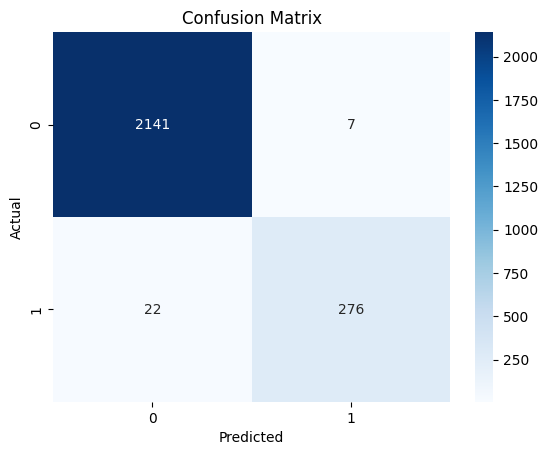

In [19]:
# === 혼동 행렬 시각화 ===
from sklearn.metrics import f1_score, classification_report, confusion_matrix

cm = confusion_matrix(y, oof_preds_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [21]:
# === 테스트 데이터 예측 및 저장 ===
test_preds_binary = (test_preds > 0.5).astype(int)
print(test_preds_binary.sum())

submit = pd.read_csv('/content/drive/My Drive/sample_submission.csv')
submit['허위매물여부'] = test_preds_binary
submit.to_csv('submission.csv', index=False)

57


In [ ]:
num_fake_listings = (submission['허위매물여부']==1).sum()
num_listings = len(submission)
print(f"허위매물(1) 개수: {num_listings} 중 {num_fake_listings}개")

허위매물(1) 개수: 613 중 60개


### AutoTabPFNClassifier

In [ ]:
!pip install tabpfn-extensions # Install tabpfn_extensions using pip
from tabpfn_extensions.post_hoc_ensembles.sklearn_interface import AutoTabPFNClassifier

# === Out-of-Fold 예측값 및 Test 예측값 초기화 ===
oof_preds = np.zeros(len(x_scaled))
test_preds = np.zeros(len(test_scaled))

# 모델 생성 (AutoTabPFN 사용)
model = AutoTabPFNClassifier(device='cuda' if torch.cuda.is_available() else 'cpu')

# 모델 학습
model.fit(X_resampled, y_resampled)

# 예측 및 저장
oof_preds = model.predict_proba(x_scaled)[:, 1]  # 훈련 데이터 예측값 저장
test_preds = model.predict_proba(test_scaled)[:, 1]  # 테스트 데이터 예측값 저장

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 25.8 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.13.2
    Uninstalling seaborn-0.13.2:
      Successfully uninstalled seaborn-0.13.2


/content/TabPFN/src/tabpfn/base.py:88: UserWarning: Downloading model to /usr/local/lib/python3.11/dist-packages/tabpfn_extensions/hpo/hpo_models/tabpfn-v2-classifier-od3j1g5m.ckpt.
  model, _, config_ = load_model_criterion_config(


tabpfn-v2-classifier-od3j1g5m.ckpt:   0%|          | 0.00/29.0M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

/content/TabPFN/src/tabpfn/base.py:88: UserWarning: Downloading model to /usr/local/lib/python3.11/dist-packages/tabpfn_extensions/hpo/hpo_models/tabpfn-v2-classifier-llderlii.ckpt.
  model, _, config_ = load_model_criterion_config(


tabpfn-v2-classifier-llderlii.ckpt:   0%|          | 0.00/29.0M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

INFO:tabpfn_extensions.post_hoc_ensembles.greedy_weighted_ensemble:Order of selections: [0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0]
INFO:tabpfn_extensions.post_hoc_ensembles.greedy_weighted_ensemble:Val loss over iterations: [-0.9909083083361475, -0.9911069614679142, -0.9911599356363854, -0.9911599356363854, -0.9912129098048564, -0.9912129098048564, -0.9912129098048564, -0.9912129098048564, -0.9912129098048564, -0.9912129098048564, -0.9912129098048564, -0.9912129098048564, -0.9912129098048564, -0.9912129098048564, -0.9912129098048564, -0.9912129098048564, -0.9912129098048564, -0.9912129098048564, -0.9912129098048564, -0.9912129098048564, -0.9912129098048564, -0.9912129098048564, -0.9912129098048564, -0.9912129098048564, -0.9912129098048564]
INFO:tabpfn_extensions.post_hoc_ensembles.greedy_weighted_ensemble:Model losses: [-0.99090831 -0.99065668 -0.99016005]
INFO:tabpfn_extensions.post_hoc_ensembles.greedy_weighted_ensemble:Best weights: [0.6 0.4 0. ]


In [ ]:
# === 검증 데이터 평가 ===
oof_preds_binary = (oof_preds > 0.5).astype(int)
print("OOF F1 Score:", f1_score(y, oof_preds_binary, average='macro'))

OOF F1 Score: 0.9766665394741862


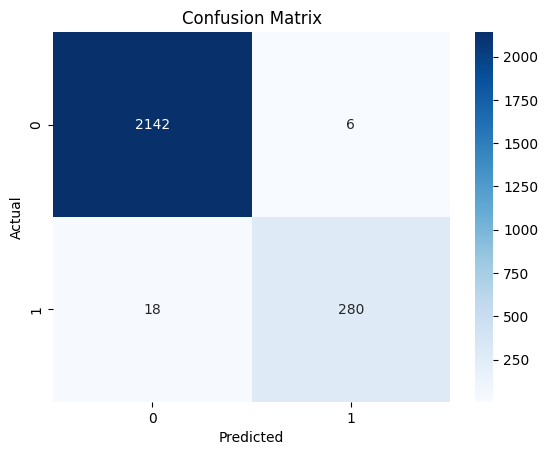

In [ ]:
# === 혼동 행렬 시각화 ===
from sklearn.metrics import f1_score, classification_report, confusion_matrix

cm = confusion_matrix(y, oof_preds_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# === 테스트 데이터 예측 및 저장 ===
test_preds_binary = (test_preds > 0.5).astype(int)
submission = pd.DataFrame({'ID': test_id, '허위매물여부': test_preds_binary})
submission.to_csv('basic_submission_autotabpfn.csv', index=False)
print("Submission file saved to 'basic_submission_autotabpfn.csv'")

Submission file saved to 'basic_submission_autotabpfn.csv'


In [ ]:
num_fake_listings = (submission['허위매물여부']==1).sum()
num_listings = len(submission)
print(f"허위매물(1) 개수: {num_listings} 중 {num_fake_listings}개")

허위매물(1) 개수: 613 중 61개


### LGBM

In [ ]:
from collections import Counter

class_counts = Counter(y)
print("클래스 분포:", class_counts)

scale_pos_weight = class_counts[0] / class_counts[1]
print("scale_pos_weight:", scale_pos_weight)

클래스 분포: Counter({0: 2148, 1: 298})
scale_pos_weight: 7.208053691275167


In [ ]:
# roc-auc로 최적화
!pip install scikit-optimize
from skopt import BayesSearchCV
from lightgbm import LGBMClassifier

# 베이지안 최적화 실행
bayes_search = BayesSearchCV(
    LGBMClassifier(boosting_type='gbdt',
                #    is_unbalance=True,
                   scale_pos_weight=scale_pos_weight
                   ),
    {
        'num_leaves': (20, 150),
        'max_depth': (3, 10),
        'learning_rate': (0.01, 0.1),
        'min_data_in_leaf': (5, 100),
        'n_estimators': (100, 1000)
    },
    n_iter=20, scoring='roc_auc', cv=5, random_state=42, n_jobs=-1
)

bayes_search.fit(X_resampled, y_resampled)
print("최적 하이퍼파라미터:", bayes_search.best_params_)
print("최적 roc-auc:", bayes_search.best_score_)


[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39
[LightGBM] [Info] Number of positive: 644, number of negative: 2148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000736 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1638
[LightGBM] [Info] Number of data points in the train set: 2792, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.230659 -> initscore=-1.204594
[LightGBM] [Info] Start training from score -1.204594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

In [ ]:
bayes_search.best_score_

0.9919119967039451

In [ ]:
bayes_search.best_params_

OrderedDict([('learning_rate', 0.06553714226520847),
             ('max_depth', 8),
             ('min_data_in_leaf', 39),
             ('n_estimators', 887),
             ('num_leaves', 97)])

In [ ]:
# bayes_search.fit(X_resampled, y_resampled)
test['허위매물여부'] = bayes_search.predict(test_scaled)
test['허위매물여부'].value_counts()

[LightGBM] [Warning] min_data_in_leaf is set=39, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=39


,count
허위매물여부,
0,552
1,61


In [ ]:
submission = pd.DataFrame({'ID':test_id, '허위매물여부' : test['허위매물여부']})
submission.to_csv('submission_lgbm.csv', index=False)

### XGBOOST

In [ ]:
!pip install optuna

In [ ]:
def objective_repeated(trial):
    # alpha 값을 hyperparameter로 최적화 (예: 0.1)
    alpha = trial.suggest_float("alpha", 0.1, 2.0)

    # 전처리 파이프라인 실행: alpha 값 반영 (feature_transform 함수에 alpha 인자 추가)
    # 여기서 train 데이터에 대해 전처리 및 인코딩을 수행합니다.
    train_transformed, one_hot_encoder, label_encoder, agency_stats, quantiles = feature_transform(
        train, is_train=True, alpha=alpha
    )

    # 전처리된 데이터에서 X와 y 추출
    X = train_transformed.drop(columns=["허위매물여부"])
    y = train_transformed["허위매물여부"]

    # 불균형 처리: 새로운 y_new에 따른 scale_pos_weight (또는 기존 값을 사용할 수 있음)
    scale_pos_weight_new = np.sum(y == 0) / np.sum(y == 1)

    # K-Fold 반복 교차 검증 (Repeated Stratified K-Fold)
    rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    scores = []

    for train_idx, valid_idx in rskf.split(X, y):
        X_train_cv, X_valid_cv = X.iloc[train_idx], X.iloc[valid_idx]
        y_train_cv, y_valid_cv = y.iloc[train_idx], y.iloc[valid_idx]

        dtrain_cv = xgb.DMatrix(X_train_cv, label=y_train_cv)
        dvalid_cv = xgb.DMatrix(X_valid_cv, label=y_valid_cv)

        # XGBoost 하이퍼파라미터 설정 (alpha는 이미 반영된 전처리 파이프라인에 포함됨)
        params = {
            "objective": "binary:logistic",
            "eval_metric": "logloss",
            "random_state": 42,
            "scale_pos_weight": scale_pos_weight_new,
            "max_depth": trial.suggest_int("max_depth", 3, 15),
            "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
            "subsample": trial.suggest_float("subsample", 0.6, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
            "gamma": trial.suggest_float("gamma", 0, 5),
            "reg_alpha": trial.suggest_float("reg_alpha", 0, 5),
            "reg_lambda": trial.suggest_float("reg_lambda", 0, 5),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 10)
        }
        num_boost_round = trial.suggest_int("num_boost_round", 100, 1000)

        early_stopping = EarlyStopping(rounds=20, data_name="validation")
        model = xgb.train(
            params=params,
            dtrain=dtrain_cv,
            num_boost_round=num_boost_round,
            evals=[(dvalid_cv, "validation")],
            callbacks=[early_stopping],
            verbose_eval=False
        )

        y_pred = (model.predict(dvalid_cv) > 0.5).astype(int)
        scores.append(f1_score(y_valid_cv, y_pred))

    return np.mean(scores)

# Optuna 최적화 실행 (Trial 수 100회)
study_repeated = optuna.create_study(direction="maximize")
study_repeated.optimize(objective_repeated, n_trials=100)
print("Best hyperparameters (Repeated CV):", study_repeated.best_params)
print("Best F1 Score (Repeated CV):", study_repeated.best_value)

[I 2025-02-19 18:46:48,897] A new study created in memory with name: no-name-efc19d35-ee80-439b-bf91-b5707e6605cc
[I 2025-02-19 18:46:52,224] Trial 0 finished with value: 0.8449506447716123 and parameters: {'alpha': 0.6056344176467773, 'max_depth': 3, 'learning_rate': 0.26795333445118247, 'subsample': 0.8566351884291168, 'colsample_bytree': 0.8002603875151664, 'gamma': 0.5810608337596451, 'reg_alpha': 1.3379773292833415, 'reg_lambda': 3.5062865175400937, 'min_child_weight': 4, 'num_boost_round': 371}. Best is trial 0 with value: 0.8449506447716123.
[I 2025-02-19 18:46:57,647] Trial 1 finished with value: 0.8552190522342683 and parameters: {'alpha': 0.7147997224418516, 'max_depth': 3, 'learning_rate': 0.13348396353099792, 'subsample': 0.9190906528944868, 'colsample_bytree': 0.7189966701053571, 'gamma': 0.010780959314211636, 'reg_alpha': 1.5230336849434567, 'reg_lambda': 0.2354256152145684, 'min_child_weight': 3, 'num_boost_round': 551}. Best is trial 1 with value: 0.8552190522342683.
[I

Best hyperparameters (Repeated CV): {'alpha': 0.750607483045684, 'max_depth': 6, 'learning_rate': 0.014438063259718756, 'subsample': 0.9458278711601354, 'colsample_bytree': 0.8686199288118331, 'gamma': 0.23462588925107228, 'reg_alpha': 0.1707528137104166, 'reg_lambda': 0.27302953778184835, 'min_child_weight': 1, 'num_boost_round': 531}
Best F1 Score (Repeated CV): 0.8714011453246311


In [ ]:
# 데이터 업로드

train = pd.read_csv('/content/drive/My Drive/train.csv')
test = pd.read_csv('/content/drive/My Drive/test.csv')

In [ ]:
train = transform(train)
test = transform(test)
# training set만: outlier drop
train = train[~((train["총주차대수"] == 590) | ((train["총주차대수"] > 120) & (train["총층"] < 10)))]
train = train[train.관리비 < 40]
# 다른 outlier 들도 확인
# EDA 에서 확인 완료! (총주차대수, 관리비만 극심한 outlier 들 존재)

In [ ]:
X = train.drop(columns=["허위매물여부"])
y = train["허위매물여부"]
scale_pos_weight = np.sum(y == 0) / np.sum(y == 1)

In [ ]:
# 최적의 하이퍼파라미터 추출 (Optuna 결과에서)
best_params = study_repeated.best_params.copy()

# 최적화 대상에 포함한 num_boost_round와 alpha도 추출
num_boost_round = best_params.pop("num_boost_round")
alpha_value = best_params.pop("alpha")  # alpha가 존재하면 추출, 없으면 None 반환

# 필요한 파라미터 추가: 평가 지표 및 불균형 처리
best_params["eval_metric"] = "logloss"
best_params["scale_pos_weight"] = scale_pos_weight

# 찾은 최적의 alpha 값을 사용해 feature_transform 재실행
# transform() 함수로 기본 전처리 후, feature_transform()을 alpha를 반영하여 적용
# (이전에 이미 transform()을 실행했다면, feature_transform()을 다시 실행)
train_transformed, one_hot_encoder, label_encoder, agency_stats, quantiles = feature_transform(
    train, is_train=True, alpha=alpha_value
)

# 전처리된 데이터에서 X와 y 추출
X_final = train_transformed.drop(columns=["허위매물여부"])
y_final = train_transformed["허위매물여부"]

# 전체 train 데이터를 DMatrix로 변환
dtrain = xgb.DMatrix(X_final, label=y_final)

# 최종 모델 학습 (Early Stopping은 hold-out set이 있다면 추가 가능)
final_model = xgb.train(
    params=best_params,
    dtrain=dtrain,
    num_boost_round=num_boost_round,
    verbose_eval=True
)

# 이후 test 데이터 전처리 시에도 동일한 feature_transform (alpha 적용) 사용
# (예: test_transformed, _, _, _ = feature_transform(test, is_train=False, one_hot_encoder=one_hot_encoder, label_encoder=label_encoder, df=train_transformed))


In [ ]:
# test 에도 feature_transform 적용
test = feature_transform(test, is_train=False, one_hot_encoder=one_hot_encoder,
                         label_encoder=label_encoder, df=agency_stats, quantile=quantiles, alpha = alpha_value)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
# 테스트 데이터 DMatrix로 변환 (전처리된 test 데이터 사용)
dtest = xgb.DMatrix(test.drop(columns=["허위매물여부"], errors="ignore"))

# 확률 예측 후 0.5 임계값으로 이진 분류
test_pred_proba = final_model.predict(dtest)
test_pred = (test_pred_proba > 0.5).astype(int)
print(test_pred.sum())

submit = pd.read_csv('/content/drive/My Drive/sample_submission.csv')
submit['허위매물여부'] = test_pred
submit.to_csv('submission.csv', index=False)

71


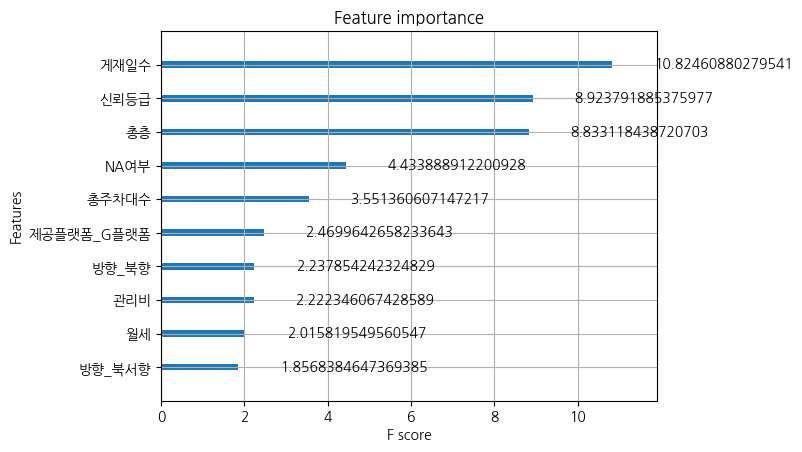

In [ ]:
import matplotlib.pyplot as plt
xgb.plot_importance(final_model, importance_type="gain", max_num_features=10)
plt.show()

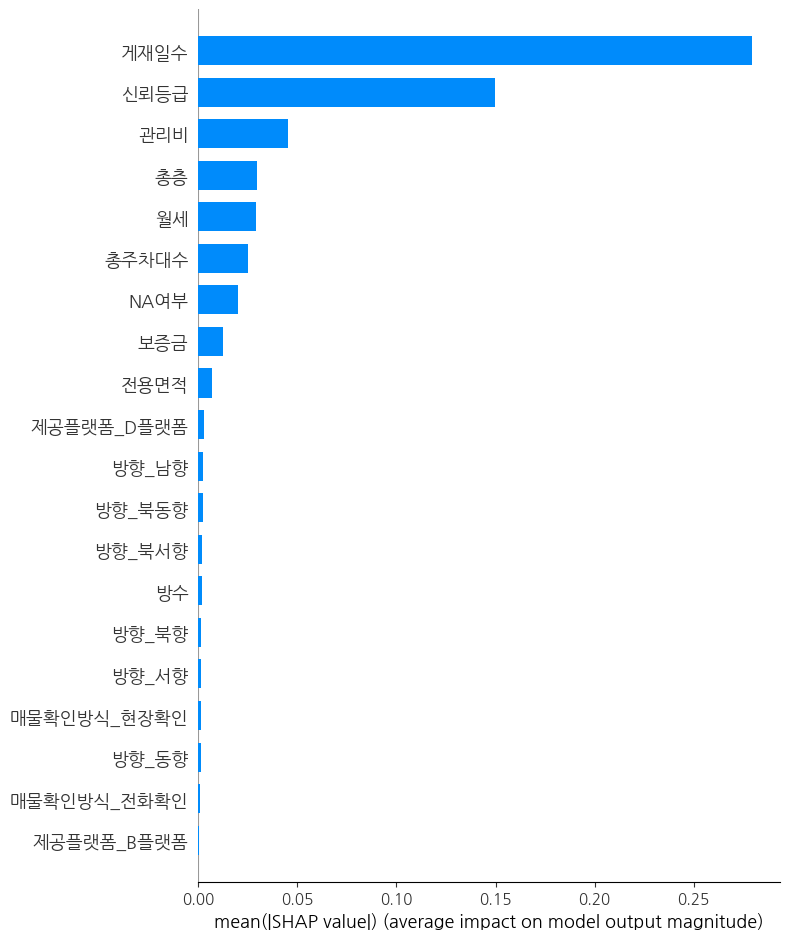

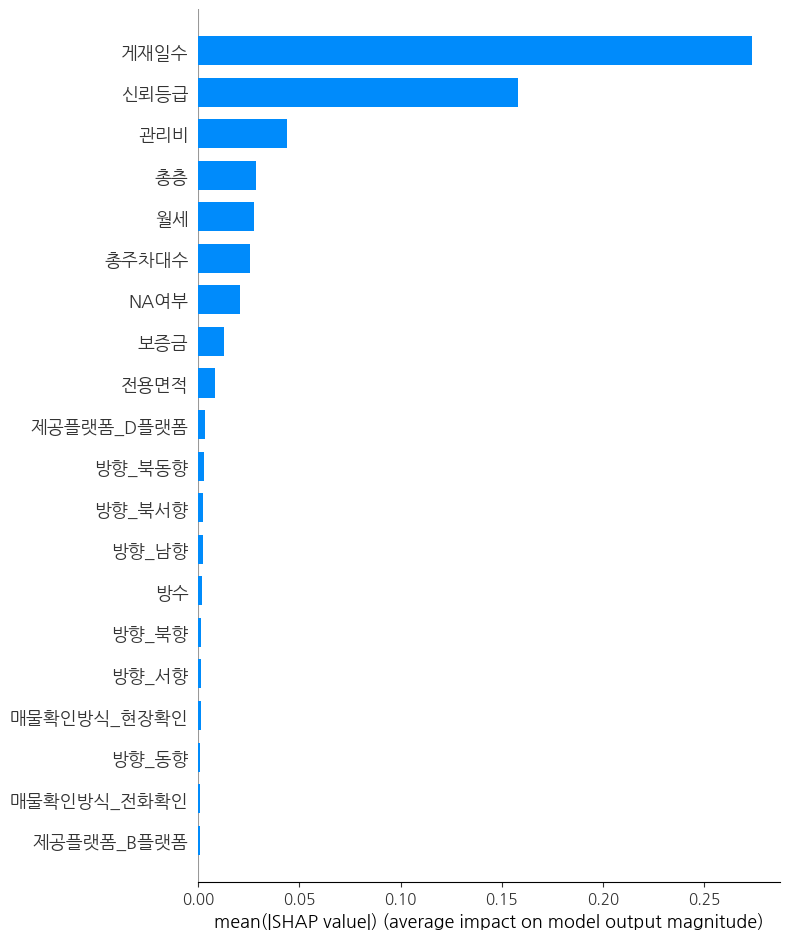

/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:950: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  pl.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


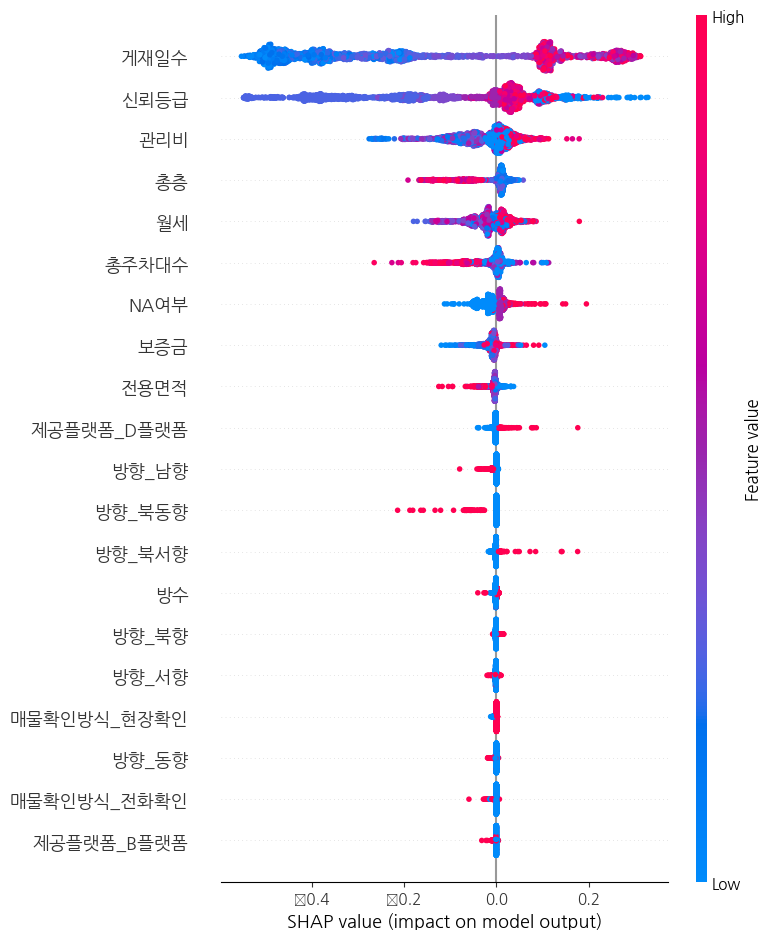

/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:950: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  pl.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumGothic.
  fig.canvas.print_figure(bytes_io, **kw)


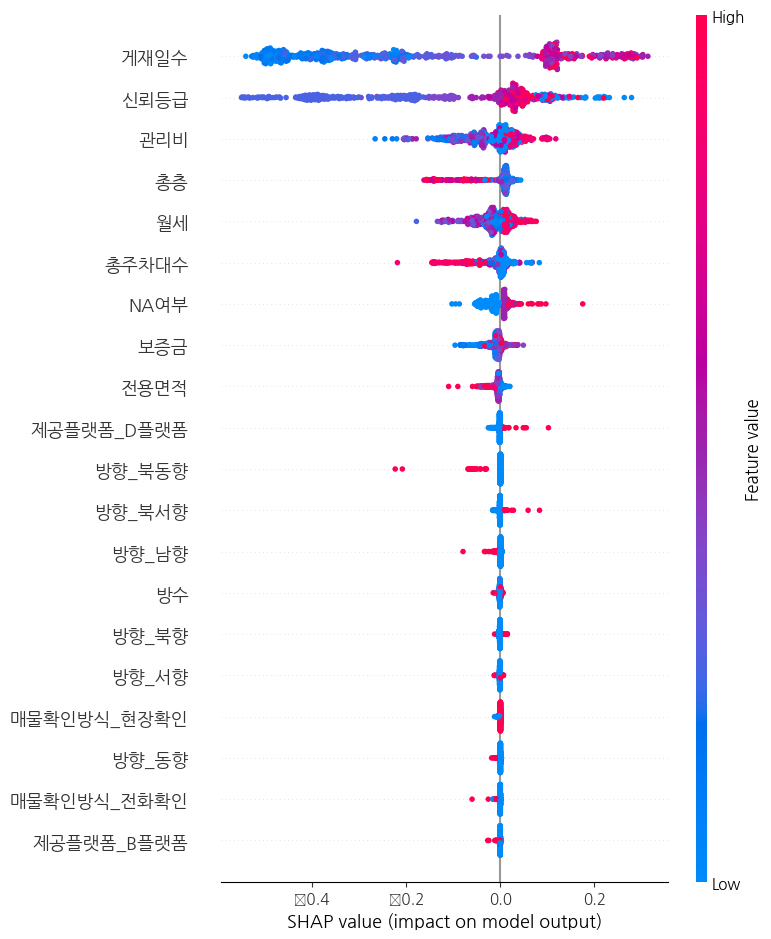

In [ ]:
# Shap value

import shap

# 최종 모델(final_model)과 DMatrix 형태의 데이터를 있다고 가정
# final_model: xgb.train()으로 학습한 최종 모델
# dtrain_full: 전체 train 데이터의 DMatrix
# X_train_full: 전체 train 데이터 (Pandas DataFrame)
# dtest: 테스트 데이터 DMatrix
# X_test: 테스트 데이터 (Pandas DataFrame)

# 1. Train 데이터에 대한 SHAP 값 계산 및 시각화
explainer_train = shap.Explainer(final_model)
shap_values_train = explainer_train(X_final)

# 2. Test 데이터에 대한 SHAP 값 계산 및 시각화
explainer_test = shap.Explainer(final_model)
shap_values_test = explainer_test(test)

shap.summary_plot(shap_values_train, X_final, plot_type="bar")
shap.summary_plot(shap_values_test, test, plot_type="bar")
shap.summary_plot(shap_values_train, X_final)
shap.summary_plot(shap_values_test, test)

# (선택) 특정 샘플에 대한 Force Plot
# shap.initjs()
# shap.force_plot(explainer_test.expected_value, shap_values_test[0,:], X_test.iloc[0,:])


# 새 섹션